In [1]:
import jax
import jaxlib

print("jax version:", jax.__version__)
print("jaxlib version:", jaxlib.__version__)

import scvi
import h5py
import numpy as np
import anndata as ad
import pandas as pd
import scipy.sparse as sp
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
from torch.optim import Adam
from scipy.sparse import issparse

#Read in our AnnData
atse_anndata = ad.read_h5ad('/Users/smriti/documents/Research_Knowles_Lab/multivi_tools_splicing/ann_data/ATSE_Anndata_Object_BRAIN_only_20241105_wLeafletFAPSIs.h5ad', backed = 'r')

jax version: 0.4.34
jaxlib version: 0.4.34


/Users/smriti/opt/anaconda3/envs/scvi-env/lib/python3.12/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_atse_counts' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/Users/smriti/opt/anaconda3/envs/scvi-env/lib/python3.12/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_junc_counts' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/Users/smriti/opt/anaconda3/envs/scvi-env/lib/python3.12/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


In [2]:
atse_anndata.var.shape[0]

54076

In [3]:
#AnnDataDataset Class helps to store layers as a dictionary that contain tensors for each layer so that we can batch them. 
class AnnDataDataset(Dataset):
    def __init__(self, layer_tensors):
        self.layer_tensors = layer_tensors
        self.num_samples = list(layer_tensors.values())[0].shape[0]

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return {layer_key: tensor[idx] for layer_key, tensor in self.layer_tensors.items()}

In [87]:
#Encoder Class - takes inputs and outputs latent variables mean and variance
class Encoder(nn.Module):
    def __init__(self, input_dim, num_hidden_layers, num_hidden_units, latent_dim, dropout_rate = 0.0):
        super().__init__()
        #consists of 1 input layer, then a series of hidden layers (which can be defined in the params), and 1 output layer
        #takes input and outputs TWO latent representation parameters with latent_dim number of dimensions, means and variances for our Normal Distribution
        #latent representation

        #input layer includes relu and dropout
        self.input = nn.Sequential(nn.Linear(input_dim, num_hidden_units[0]), nn.ReLU(), nn.Dropout(dropout_rate))
        self.hidden_layers = []
        #adding linear layers, each with relu and dropout. dimensions are defined in num_hidden_units
        for i in range (num_hidden_layers):
            self.hidden_layers.append(nn.Sequential(nn.Linear(num_hidden_units[i], num_hidden_units[i+1]), nn.ReLU(), nn.Dropout(dropout_rate)))
        #we output the two different latent rep parameters here. 
        self.output_means = nn.Linear(num_hidden_units[len(num_hidden_units) - 1], latent_dim)
        self.output_log_vars = nn.Linear(num_hidden_units[len(num_hidden_units) - 1], latent_dim)

    #forward pass through all our layers
    def forward(self, x):
        x = self.input(x)
        for layer in self.hidden_layers:
             x = layer(x)
        means = self.output_means(x)
        log_vars = self.output_log_vars(x)
        return means, log_vars

#Decoder Class takes in reparametrized latent representation (z) and creates a logit reconstruction
class Decoder(nn.Module):
    def __init__(self, z_dim, num_hidden_layers, num_hidden_units, output_dim, dropout_rate = 0.0):
        super().__init__()
        #similar to encoder, except input dim = latent dim from earlier
        self.input = nn.Sequential(nn.Linear(z_dim, num_hidden_units[-1]), nn.ReLU(), nn.Dropout(dropout_rate))
        self.hidden_layers = []
        #in same way as in encoder we add the hidden layers except in reverse order for the dimensions
        for i in reversed(range(num_hidden_layers)):
            self.hidden_layers.append(nn.Sequential(nn.Linear(num_hidden_units[i+1], num_hidden_units[i]), nn.ReLU(), nn.Dropout(dropout_rate)))
        #output a raw logit representing the reconstruction
        self.output = nn.Linear(num_hidden_units[0], output_dim)

    #forward pass through all our layers
    def forward(self, x):
        x = self.input(x)
        for layer in self.hidden_layers:
             x = layer(x)
        m = nn.Sigmoid()
        reconstruction = m(self.output(x))
        return reconstruction
from torch.distributions import Normal
from torch.distributions.kl import kl_divergence
#Binomial loss function includes reconstruction loss and KL divergence
def binomial_loss_function(logits, junction_counts, mean, log_vars, n_cluster_counts):
    probabilities = torch.sigmoid(logits)

    log_probabilities = torch.log(probabilities + 1e-10)  # Add epsilon to avoid log(0)
    log_complement_probabilities = torch.log(1 - probabilities + 1e-10)  # Avoid log(0)
    
    # Log-likelihood calculation
    log_likelihood = (
        junction_counts * log_probabilities +
        (n_cluster_counts - junction_counts) * log_complement_probabilities
    )
    reconstruction_loss = -log_likelihood.mean()  # Negative log-likelihood as loss
    
    # Compute KL divergence using PyTorch's distributions
    qz = Normal(mean, torch.sqrt(torch.exp(log_vars)))  # Approximate posterior
    pz = Normal(0, 1)  # Prior
    kl_dive = kl_divergence(qz, pz).sum(dim=1).mean()  # Average over batch
    
    # Total loss
    total_loss = reconstruction_loss + (0.0001 * kl_dive)
    return total_loss

#Takes the ATSE AnnData and convert it into a tensor 
def construct_input_dataloaders(atse_anndata, batch_size, validation_split = 0.2):
    layer_tensors = {
        layer_key: torch.tensor(atse_anndata.layers[layer_key].toarray() if issparse(atse_anndata.layers[layer_key]) else atse_anndata.layers[layer_key], dtype=torch.float32)
        for layer_key in list(atse_anndata.layers.keys())[:3] #dictionary of PyTorch tensors that are derived from the first three layers of the AnnData object
    } #if sparse matrix, then we convert to a numpy array, and we also make sure to cast it to float32 or else pytorch gets mad at me
    dataset = AnnDataDataset(layer_tensors) #put it into our new dataset class defined earlier

    #computing sizes...
    total_size = len(dataset)
    val_size = int(total_size * validation_split)
    train_size = total_size - val_size

    train_dataset, val_dataset = random_split(dataset, [train_size, val_size]) #split our dataset into training and validaton
    full_dataset = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    #will need to implement validation set and test set probably so I can do early stopping and do some umaps to visualize how the cells are in latent space
    return full_dataset, train_dataloader, val_dataloader

#Our main VAE model! Takes inputs, encodes them as latent parameters (mean, var), reparametrizes them (z), then decodes them as logit reconstructions
#loss is based on how well z can be used to "reconstruct" the junction counts, given the ATSE counts. in this way, z is sort of like a denoised representation
#of the junction usage ratios (?)
class VAE(nn.Module):
    def __init__(self, input_dim, num_hidden_layers, num_hidden_units, latent_dim, output_dim, dropout_rate = 0.0):
        super().__init__()
        #creating our encoder + decoder given our VAE parameters. 
        self.encoder = Encoder(input_dim, num_hidden_layers, num_hidden_units, latent_dim, dropout_rate)
        self.decoder = Decoder(latent_dim, num_hidden_layers, num_hidden_units, output_dim, dropout_rate)
    
    #reparametrization trick. typically, we'd need to draw z directly from the MVN to sample our latent variable
    #as z = N(mean, var)
    #but this makes it hard to calculate the gradient later because its stochastic.
    #so instead, we represent z as z=mean+ std⋅eps where 
    #our epsilon is noise to introduce a bit of variability 
    def reparametrize(self, mean, log_vars):
        std = torch.exp(0.5 * log_vars) 
        eps = torch.randn_like(std)
        return mean + eps * std  
    
    #forward pass through our layers
    def forward(self, x):
        mean, log_vars = self.encoder(x) #get the mean and var from the encoder
        z = self.reparametrize(mean, log_vars) #reparametrize to get our z (latent representation)
        reconstruction = self.decoder(z) #feed this latent rep directly into our decoder to get our reconstructed logit

        reconstruction = reconstruction.to(torch.float32) #make sure its a float!
        mean = mean.to(torch.float32) #make this this is also a float (pytorch kept yelling at me)
        log_vars = log_vars.to(torch.float32)
        
        return reconstruction, mean, log_vars
    
    #finally, we train our model!
    def train_model(self, train_dataloader, val_dataloader, num_epochs, learning_rate, patience):
        print("Beginning Training")
        #using adam optimizer
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
        train_losses = []
        val_losses = []
        best_val_loss = float('inf')
        bad_epochs = 0
        for epoch in range(num_epochs):
            epoch_loss = 0
            self.train() #putting our model in train mode
            for batch in train_dataloader:
                optimizer.zero_grad()
                reconstruction, mean, log_vars = self.forward(batch["junc_ratio"]) #calling forward on our junction ratios from the batch
                loss = binomial_loss_function(reconstruction, batch["cell_by_junction_matrix"], mean, log_vars, batch["cell_by_cluster_matrix"]) #getting our
                #loss, giving the loss function all necessary parameters including the junction and cluster counts
                loss.backward() #backward pass
                epoch_loss += loss.item()
                optimizer.step()
            train_epoch_loss = epoch_loss / len(train_dataloader)
            print(f"Epoch {epoch+1}/{num_epochs}; Train Loss = {train_epoch_loss}")
            train_losses.append(train_epoch_loss)
            scheduler.step()

            #validation of the data
            self.eval()
            val_loss = 0
            with torch.no_grad():
                for batch in val_dataloader:
                    reconstruction, mean, log_vars = self.forward(batch["junc_ratio"]) #calling forward, again
                    val_batch_loss = binomial_loss_function(reconstruction, batch["cell_by_junction_matrix"], mean, log_vars, batch["cell_by_cluster_matrix"])
                    val_loss += val_batch_loss.item() 
            val_epoch_loss = val_loss / len(val_dataloader) #calculating the validation loss
            val_losses.append(val_epoch_loss)
            print(f"Validation Loss = {val_epoch_loss}")
            
            if val_epoch_loss < best_val_loss: #if we get a better validation loss, we update the best one and reset the patience
                best_val_loss = val_epoch_loss
                torch.save(self.state_dict(), f"/Users/smriti/Documents/Research_Knowles_Lab/multivi_tools_splicing/best_model.py")
                bad_epochs = 0
            else:
                bad_epochs += 1 #running out of patience...

            if bad_epochs >= patience: #ran out of patience!
                print("Early stopping triggered. Ran out of patience")
                break
        self.load_state_dict(torch.load(f"/Users/smriti/Documents/Research_Knowles_Lab/multivi_tools_splicing/best_model.py"))
        return train_losses, val_losses
    def get_latent_rep(self, layer):
        latent_representations = []
        self.encoder.eval()  
        with torch.no_grad(): 
            mean, log_vars = self.encoder(layer) 
            z = self.reparametrize(mean, log_vars)
            latent_representations.append(z)
        latent_representations = torch.cat(latent_representations, dim=0)
        latent_representations_np = latent_representations.numpy()
        return latent_representations_np

In [71]:
import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

In [38]:
#using Karin's parameters from her VAE for now, will change once I run this on the cluster.
LEARNING_RATE = 1e-3
NUM_EPOCHS = 10
BATCH_SIZE = 128
USE_CUDA = torch.cuda.is_available()
INPUT_DIM = atse_anndata.var.shape[0]
NUM_HIDDEN_LAYERS = 1
HIDDEN_DIMS = [128, 64] 
LATENT_DIM = 100
OUTPUT_DIM = INPUT_DIM 

In [ ]:
#getting our dataloader from the atse anndata, given our batch size. 
full_dataloader, train_dataloader, val_dataloader = construct_input_dataloaders(atse_anndata, BATCH_SIZE)

Beginning Training
Epoch 1/10; Train Loss = 5.119106098175049
Validation Loss = 5.057646572589874
Epoch 2/10; Train Loss = 4.78492470741272
Validation Loss = 5.054098203778267
Epoch 3/10; Train Loss = 4.791293607711792
Validation Loss = 5.052828632295132
Epoch 4/10; Train Loss = 4.784032289505005
Validation Loss = 5.052485018968582
Epoch 5/10; Train Loss = 4.780673278808594
Validation Loss = 5.051356688141823
Epoch 6/10; Train Loss = 4.78033703994751
Validation Loss = 5.050144165754318
Epoch 7/10; Train Loss = 4.778392503738403
Validation Loss = 5.049519948661327
Epoch 8/10; Train Loss = 4.779453786849976
Validation Loss = 5.049452804028988
Epoch 9/10; Train Loss = 4.779167919158936
Validation Loss = 5.048886984586716
Epoch 10/10; Train Loss = 4.789461740493774
Validation Loss = 5.04801432788372


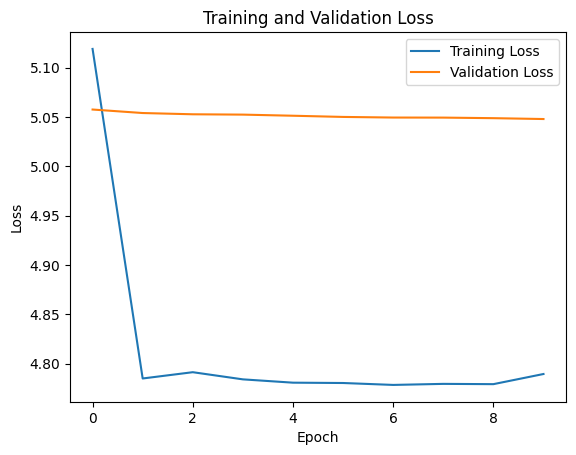

In [88]:
#training call! puts it on our GPU if available
model = VAE(INPUT_DIM, NUM_HIDDEN_LAYERS, HIDDEN_DIMS, LATENT_DIM, OUTPUT_DIM)
if USE_CUDA:
    model.cuda()

train_losses, val_losses = model.train_model(train_dataloader, val_dataloader, NUM_EPOCHS, learning_rate = 1e-3, patience=5)
plot_losses(train_losses, val_losses)

In [89]:
lr = model.get_latent_rep(torch.tensor(atse_anndata.layers['junc_ratio'].toarray(), dtype=torch.float32))

cell_type_grouped
MICROGLIA               12796
GLIAL CELL               2937
ENDOTHELIAL CELL         2196
NEURON                    794
PERICYTE                  481
MACROPHAGE                309
T CELL                    185
NEUROEPITHELIAL CELL      151
STEM CELL                  93
Name: count, dtype: int64


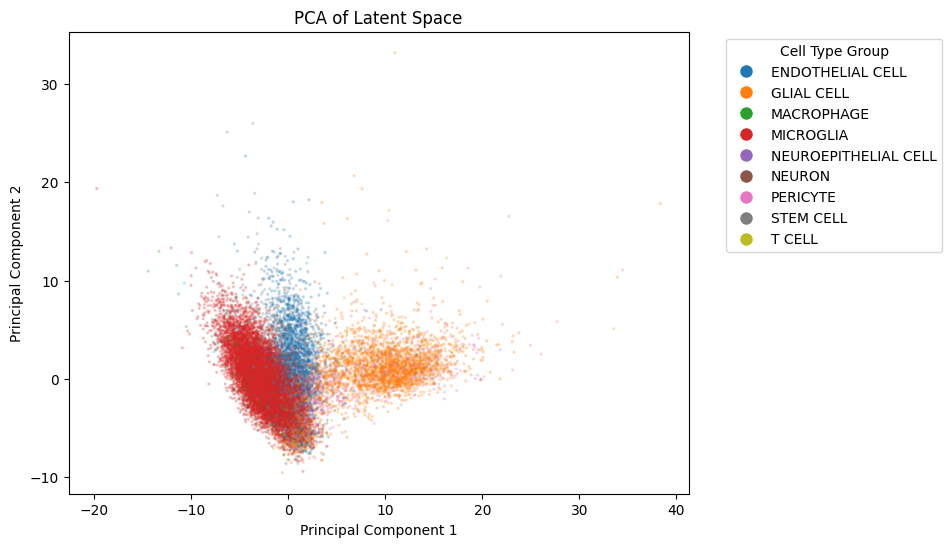

In [90]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca_model = PCA(n_components=2)
print(atse_anndata.obs['cell_type_grouped'].value_counts())
pca_latents = pca_model.fit_transform(lr)
cell_types = atse_anndata.obs['cell_type_grouped']

plt.figure(figsize=(8, 6))
scatter = plt.scatter(pca_latents[:, 0], pca_latents[:, 1], 
                      c=cell_types.astype('category').cat.codes, 
                      cmap='tab10', alpha=0.2, s = 2)
legend_labels = cell_types.astype('category').cat.categories
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.tab10(i / len(legend_labels)), markersize=10) for i in range(len(legend_labels))]
plt.legend(legend_handles, legend_labels, title="Cell Type Group", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA of Latent Space")
plt.show()

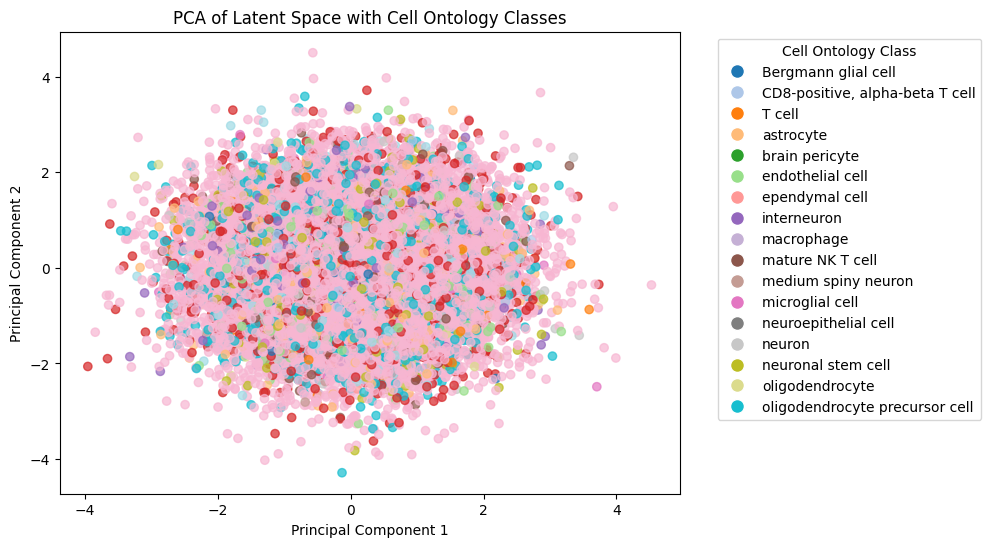

In [17]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca_model = PCA(n_components=2)
pca_latents = pca_model.fit_transform(lr)
cell_types = atse_anndata.obs['cell_ontology_class']

plt.figure(figsize=(8, 6))
scatter = plt.scatter(pca_latents[:, 0], pca_latents[:, 1], 
                      c=cell_types.astype('category').cat.codes, 
                      cmap='tab20', alpha=0.7)
legend_labels = cell_types.astype('category').cat.categories
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.tab20(i / len(legend_labels)), markersize=10) for i in range(len(legend_labels))]
plt.legend(legend_handles, legend_labels, title="Cell Ontology Class", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA of Latent Space with Cell Ontology Classes")
plt.show()